In [10]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [11]:
def load_dataset(dataset_path):
    x_train = []
    y_train = []
    class_names = sorted(os.listdir(dataset_path))

    for class_index, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(class_path, filename)
                    image = cv2.imread(image_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = np.array(image)
                    image = image / 255.0
                    if image is not None:
                        x_train.append(image)
                        y_train.append(class_index)

    x_train = np.array(x_train)
    y_train = np.array(y_train)

    return x_train, y_train

In [12]:
def create_model(input_shape, num_classes):
    # Load the MobileNetV2 model with pre-trained weights on ImageNet
    base_model = MobileNetV2(
        weights='imagenet', 
        include_top=False, 
        input_shape=input_shape
    )
    
    # Add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Add a dense layer with 128 neurons and ReLU activation
    x = Dense(128, activation='relu')(x)
    
    # Add a final dense layer with 4 neurons (one for each class) and softmax activation
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Create the new model with the modified architecture
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze the weights of the base model to avoid overfitting on small datasets
    for layer in base_model.layers:
        layer.trainable = False

    return model

In [23]:
input_shape = (224, 224, 3)
num_classes = 4
batch_size = 32
epochs = 20
lr = 0.001

In [20]:
# Dataset directory
dataset_directory = "data/MSID_US"

# Load dataset into x_train and y_train arrays
dataset_x_train, dataset_y_train = load_dataset(dataset_directory)

dataset_x_train.shape, dataset_y_train.shape

((426, 224, 224, 3), (426,))

In [6]:
# Saving loaded dataset into images and labels numpy arrays for later re-use
dataset_images_array_name = 'data/MSID_AUG_IMAGES_ARRAY.npy'
dataset_labels_array_name = 'data/MSID_AUG_LABELS_ARRAY.npy'

np.save(dataset_images_array_name, dataset_x_train);
np.save(dataset_labels_array_name, dataset_y_train);

In [ ]:
# Loading saved numpy dataset
dataset_x_train = np.load(dataset_images_array_name)
dataset_y_train = np.load(dataset_labels_array_name)

In [21]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(dataset_x_train, dataset_y_train, test_size=0.1)

# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

# Reshaping labels to (x, 4)
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

x_train.shape, x_val.shape, x_test.shape

((306, 224, 224, 3), (77, 224, 224, 3), (43, 224, 224, 3))

In [24]:
model = create_model(input_shape, num_classes)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set up the learning rate schedule
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7)

# Train the model using fit_generator with the learning rate schedule
model.fit(
    x_train, 
    y_train_one_hot,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val_one_hot), 
    callbacks=[reduce_lr], 
    verbose=1)

Epoch 1/20
10/10 [==============================] - 4s 282ms/step - loss: 1.0908 - accuracy: 0.5131 - val_loss: 0.7087 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 2s 251ms/step - loss: 0.4422 - accuracy: 0.8595 - val_loss: 0.6132 - val_accuracy: 0.7792 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 3s 261ms/step - loss: 0.2760 - accuracy: 0.9150 - val_loss: 0.5371 - val_accuracy: 0.8312 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 2s 250ms/step - loss: 0.1747 - accuracy: 0.9641 - val_loss: 0.5631 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 5/20
10/10 [==============================] - 2s 244ms/step - loss: 0.1147 - accuracy: 0.9869 - val_loss: 0.5323 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 6/20
10/10 [==============================] - 2s 239ms/step - loss: 0.0834 - accuracy: 0.9935 - val_loss: 0.5462 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 7/20
10/10 [==============================] - 2s 242ms/step - lo

In [25]:

# Predict on the validation data
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate the metrics
precision = precision_score(y_test, y_pred_labels, average='macro')
recall = recall_score(y_test, y_pred_labels, average='macro')
f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

# Print the metrics
print(f"Metrics:")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)
print()

2/2 [==============================] - 1s 98ms/step
Metrics:
Precision: 0.8846153846153846
Recall: 0.8794642857142857
F1 Score: 0.8574074074074074
Accuracy: 0.8604651162790697



In [8]:
model.save('models/mobilenetv2_original_split_validation.h5')

In [6]:
model = tf.keras.models.load_model('models/mobilenetv2_split_validation.h5')

16/16 [==============================] - 3s 181ms/step


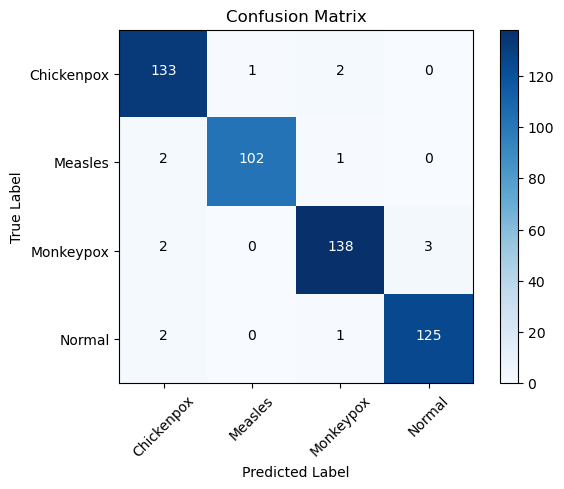

In [18]:
# Predict on the validation data
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)


y_pred_labels = np.argmax(y_pred, axis=1)  

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Class labels
class_labels = ['Chickenpox', 'Measles', 'Monkeypox', 'Normal']

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Add values to each cell of the matrix
thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Mostrar el plot
plt.show()

In [19]:
image = cv2.imread('test-images/normal-test.jpeg')

# Resize the image to the input size expected by the model
input_size = (224, 224)  # example input size for a model
image = cv2.resize(image, input_size)

# Convert the image to a NumPy array
image = np.array(image)

# Scale the pixel values to be between 0 and 1
image = image / 255.0

# Add an extra dimension to the array to represent the batch size (1 in this case)
image = np.expand_dims(image, axis=0)

image.shape

prediction = model.predict(image)

predicted_class = np.argmax(prediction)

print(predicted_class)

1/1 [==============================] - 0s 309ms/step
3
